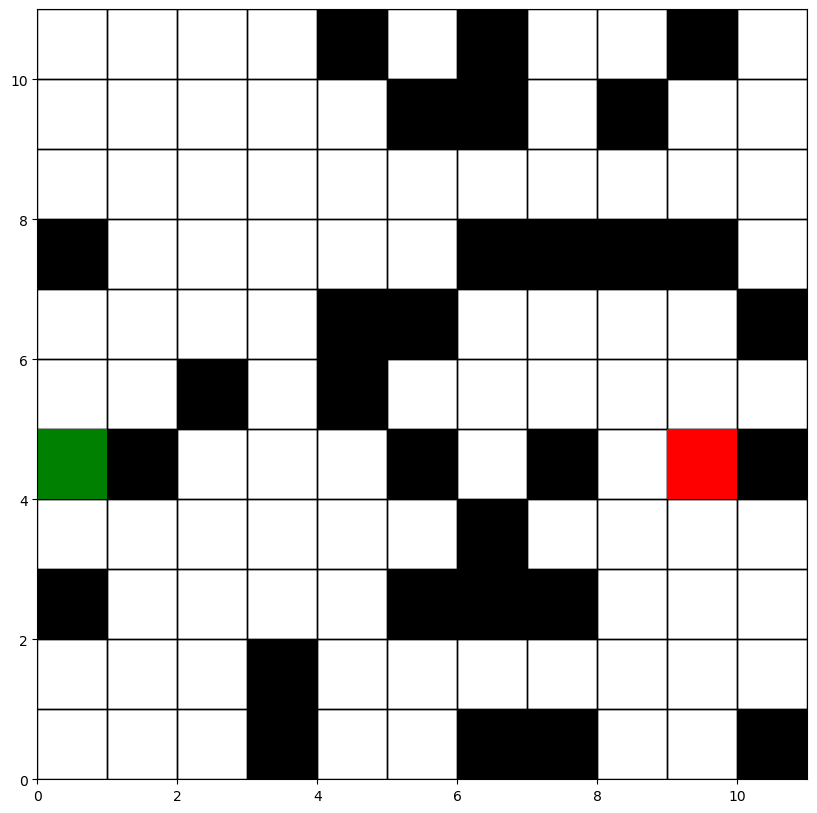

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import math
from typing import Tuple, TypeVar, List, Dict

GridLocation = Tuple[int, int]
Location = TypeVar('Location')

class SquareGrid:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.walls: List[GridLocation] = []

    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height

    def passable(self, id):
        return id not in self.walls

    def neighbors(self, id):
        (x, y) = id
        neighbors = [(x+1, y), (x-1, y), (x, y-1), (x, y+1)]
        results = filter(self.in_bounds, neighbors)
        results = filter(self.passable, results)
        return results

class GridWithWeights(SquareGrid):
    def __init__(self, width, height):
        super().__init__(width, height)
        self.weights: Dict[GridLocation, float] = {}

    def cost(self, from_node, to_node):
        return self.weights.get(to_node, 1)
    
# 壁をランダムに生成する関数
def generate_random_walls(grid, wall_ratio):
    num_walls = int(grid.width * grid.height * wall_ratio)
    while len(grid.walls) < num_walls:
        x, y = np.random.randint(grid.width), np.random.randint(grid.height)
        if (x, y) not in grid.walls:
            grid.walls.append((x, y))

# 描画用の関数
def draw_grid(grid, path=None, start=None, goal=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    for y in range(grid.height):
        for x in range(grid.width):
            rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none')
            ax.add_patch(rect)

    for wall in grid.walls:
        rect = plt.Rectangle((wall[0], wall[1]), 1, 1, facecolor='black')
        ax.add_patch(rect)

    if start:
        rect = plt.Rectangle((start[0], start[1]), 1, 1, facecolor='green')
        ax.add_patch(rect)
    if goal:
        rect = plt.Rectangle((goal[0], goal[1]), 1, 1, facecolor='red')
        ax.add_patch(rect)

    if path:
        for position in path:
            rect = plt.Rectangle((position[0], position[1]), 1, 1, facecolor='blue', alpha=0.5)
            ax.add_patch(rect)

    plt.xlim(0, grid.width)
    plt.ylim(0, grid.height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# グリッドワールドの設定と壁のランダム生成
grid = GridWithWeights(11, 11)
generate_random_walls(grid, 0.25)  # 25%の壁をランダムに配置
start, goal = (0, 4), (9, 4)

# 地図の描画
draw_grid(grid, start=start, goal=goal)


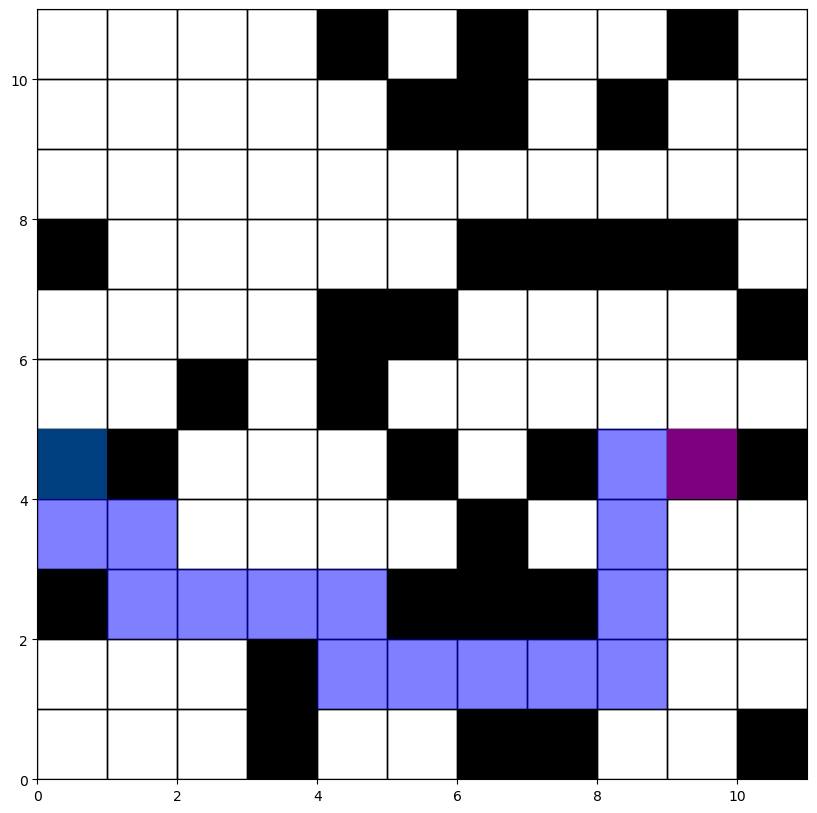

In [11]:
def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path

# ダイクストラ探索
def dijkstra(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = dict()
    cost_so_far = dict()
    came_from[start] = None
    cost_so_far[start] = 0

    while not frontier.empty():
        current = frontier.get()[1]

        if current == goal:
            break

        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost
                frontier.put((priority, next))
                came_from[next] = current

    return came_from, cost_so_far

# ダイクストラ探索の実行
came_from, cost_so_far = dijkstra(grid, start, goal)
path = reconstruct_path(came_from, start, goal)

# 結果の描画
draw_grid(grid, path, start, goal)

Episode 100/1000, Total Reward: 79
Episode 200/1000, Total Reward: 84
Episode 300/1000, Total Reward: 85
Episode 400/1000, Total Reward: 80
Episode 500/1000, Total Reward: 86
Episode 600/1000, Total Reward: 83
Episode 700/1000, Total Reward: 80
Episode 800/1000, Total Reward: 84
Episode 900/1000, Total Reward: 83
Episode 1000/1000, Total Reward: 86


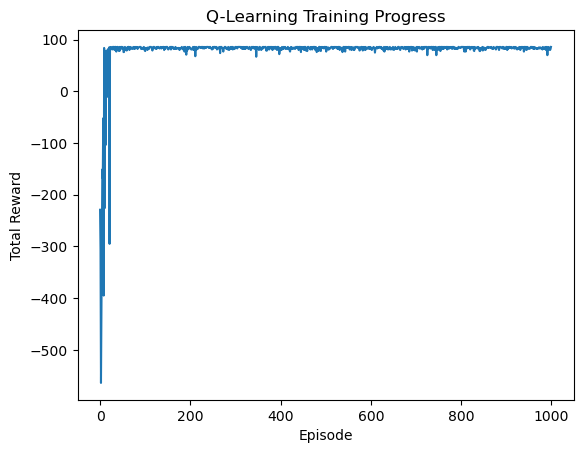

In [12]:
# Q学習の実装
q_table = np.zeros((grid.height, grid.width, 4))  # 4つの行動（上、下、左、右）

def move(state, action, grid):
    # 行動に応じて状態を更新
    # action: 0 = 上, 1 = 下, 2 = 左, 3 = 右
    next_state = list(state)
    if action == 0 and state[1] > 0:  # 上へ移動
        next_state[1] -= 1
    elif action == 1 and state[1] < grid.height - 1:  # 下へ移動
        next_state[1] += 1
    elif action == 2 and state[0] > 0:  # 左へ移動
        next_state[0] -= 1
    elif action == 3 and state[0] < grid.width - 1:  # 右へ移動
        next_state[0] += 1
    
    # 次の状態が壁であれば移動しない
    if tuple(next_state) in grid.walls:
        return state
    return tuple(next_state)

def choose_action(state, q_table, epsilon):
    if np.random.rand() < epsilon:
        action = np.random.randint(4)  # ランダムに行動選択
    else:
        action = np.argmax(q_table[state[0], state[1]])  # Q値が最大の行動選択
    return action

def update_q_table(state, action, reward, next_state, q_table, alpha, gamma):
    old_value = q_table[state[0], state[1], action]
    next_max = np.max(q_table[next_state[0], next_state[1]])
    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[state[0], state[1], action] = new_value
    return q_table

def get_reward(state, goal, grid):
    if state == goal:
        return 100  # ゴールに到達
    elif state in grid.walls:
        return -100  # 壁にぶつかる
    else:
        return -1  # それ以外の移動

epsilon = 0.1
alpha = 0.5
gamma = 0.9
num_episodes = 1000

# 学習時の様子を記録するためのリスト
episode_rewards = []

for episode in range(num_episodes):
    state = start
    total_reward = 0

    while state != goal:
        action = choose_action(state, q_table, epsilon)
        next_state = move(state, action, grid)  # エージェントを移動させる関数
        reward = get_reward(next_state, goal, grid)
        q_table = update_q_table(state, action, reward, next_state, q_table, alpha, gamma)
        state = next_state
        total_reward += reward

    episode_rewards.append(total_reward)

    # 学習の進捗を表示
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

# 学習の様子をプロット
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning Training Progress")
plt.show()